# Stanford Dogs — ResNet50 Augmentation 
## No Aug / Basic Aug / MixUp / CutMix 비교 분석

---

## 1. MixUp과 CutMix 기법을 ResNet50 분류기에 성공적으로 적용하였는가?

### 결론  
MixUp과 CutMix는 ResNet50 모델에 정상적으로 적용되었으며, 수렴 과정 또한 정상적이다.

- Soft Cross Entropy + Soft Label(one-hot interpolation)을 사용해 MixUp·CutMix 학습이 정확히 구현되었다.
- 학습 초기 train accuracy가 낮은 것은 soft label로 인한 정상적인 동작이다.
- Validation accuracy는 약 82~85% 근처에서 안정적으로 수렴했다.

---

## 2. MixUp/CutMix 적용 모델이 정상적으로 수렴하였는가?

다음과 같은 근거로 MixUp / CutMix 모델은 정상 수렴하였다.

- epoch가 진행됨에 따라 validation accuracy 상승 및 안정화
- test accuracy 또한 validation과 ±1% 이내의 차이를 보이며 안정적
- loss 감소 패턴이 일반적인 supervised learning 수렴 패턴과 동일

따라서 MixUp, CutMix는 정상적으로 동작하고 학습이 수렴했다고 판단.

---

## 3. 다양한 실험을 통해 태스크에 최적인 Augmentation 기법을 찾아내었는가?

### 결론  
Stanford Dogs dataset의 특성상 **No Aug 또는 매우 약한 Augmentation이 최적**임을 실험 결과를 통해 확인하였다.

### 근거
- Stanford Dogs는 120개 클래스의 fine-grained classification 문제이다.
- 품종마다 귀 모양, 코 비율, 눈 위치, 털 패턴 등 미세한 특징이 존재한다.
- MixUp, CutMix, 강한 Color Jitter 등은 이 핵심 시각 정보를 파괴한다.
- 결과적으로 **No Aug > CutMix ≈ MixUp > Basic Aug** 순으로 성능이 나타남.

### 실험 결과 요약

| Method | Final Val Acc | Test Acc | Rank |
|--------|----------------|----------|-------|
| No Aug | 85.07% | 84.33% | 1 |
| Basic + CutMix | 84.13% | 83.68% | 2 |
| Basic + Mixup | 84.00% | 83.00% | 3 |
| Basic Aug | 83.54% | 82.71% | 4 |

---

## 4. 각 기법 적용 후 성능 비교 분석 및 문제점 분석

### Generalization Gap 분석

| Method | Train-Val Gap | 특징 |
|--------|----------------|--------|
| No Aug | +14~17% | 강한 과적합 |
| Basic Aug | +7~13% | 과적합 감소 |
| MixUp | -1~ -6% | underfitting 경향 |
| CutMix | -10~ -17% | 강한 regularization |

- MixUp과 CutMix는 train accuracy가 낮고 gap이 작음 → 일반화에는 유리
- 그러나 fine-grained 분류에서는 train accuracy가 낮으면 feature learning이 충분히 되지 않아 성능이 떨어질 수 있음

### Robustness 분석

모든 기법에서 Validation vs Test accuracy 차이는 0~1% 범위
이는 데이터 분할과 모델 안정성이 매우 우수함을 의미

---

### 기법별 문제점 분석

#### MixUp 문제점  
- 두 품종 이미지를 섞으면 fine-grained 시각적 정보가 사라짐  
- 귀·눈·주둥이 비율 등 중요한 구조가 왜곡됨  
- train accuracy가 80% 근처에서 정체되며 충분한 특징 학습이 어려움

#### CutMix 문제점  
- 랜덤 패치 제거로 인한 시각 정보 손실  
- 얼굴, 귀, 눈 등 핵심 feature가 잘려나가는 경우가 많음  
- train accuracy가 70% 수준에서 수렴 → 강한 regularization 효과

---

## 5. Augmentation 기법을 시각화·해석·비교하여 체계적으로 분석하였는가?

다음 항목을 포함해 분석을 수행하였다.

- Validation Accuracy over Epochs
- Training Accuracy over Epochs
- Test Accuracy Bar Chart
- Generalization Gap Curve
- Validation vs Test Accuracy 비교
- Training Time 비교




## Figure 1
![Figure 1](pics/augmentation_comparison%201.png)

## Figure 2
![Figure 2](pics/augmentation_comparison%202.png)

## Figure 3
![Figure 3](pics/augmentation_comparison%203.png)

## Figure 4
![Figure 4](pics/augmentation_comparison%204.png)

## Figure 5
![Figure 5](pics/augmentation_comparison%205.png)

## Figure 6
![Figure 6](pics/augmentation_comparison.png)


In [44]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
from torchvision.transforms import RandAugment
import numpy as np
import matplotlib.pyplot as plt
import time

from collections import defaultdict

torch.backends.cudnn.benchmark = True  # conv 알고리즘 튜닝

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [ ]:
dataset_dir = "archive/images/images"

# No Augmentation Transform
transform_no_aug = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

transform_basic_aug = transforms.Compose([
    transforms.RandomResizedCrop(
        size=224,
        scale=(0.5, 1.0),     # 더 강한 스케일 변화가 성능을 가장 잘 올림
        ratio=(0.8, 1.2)      # 자연스러운 종횡비 변화
    ),
    transforms.RandomHorizontalFlip(p=0.5),
    
    # RandAugment
    RandAugment(num_ops=2, magnitude=10), # 2가지의 증강(14개)을 랜덤하게 10(1~30)의 강도로 부여
    
    transforms.ColorJitter(
        brightness=0.2,
        contrast=0.2,
        saturation=0.2
    ),
    
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    ),
])




In [ ]:
# 전체 데이터셋
full_dataset_no_aug = ImageFolder(root=dataset_dir, transform=transform_no_aug)
full_dataset_basic_aug = ImageFolder(root=dataset_dir, transform=transform_basic_aug)

# Train / Val / Test = 70% / 15% / 15%
total_size = len(full_dataset_no_aug)
train_size = int(0.7 * total_size)
val_size   = int(0.15 * total_size)
test_size  = total_size - train_size - val_size

print(f"Dataset split - Train: {train_size}, Validation: {val_size}, Test: {test_size}")

# No Aug 기준으로 split
ds_train_no_aug, ds_val_no_aug, ds_test_no_aug = random_split(
    full_dataset_no_aug,
    [train_size, val_size, test_size],
    generator=torch.Generator().manual_seed(42)
)

# 동일 seed로 Basic Aug도 같은 인덱스 분할
ds_train_basic_aug, ds_val_basic_aug, ds_test_basic_aug = random_split(
    full_dataset_basic_aug,
    [train_size, val_size, test_size],
    generator=torch.Generator().manual_seed(42)
)

# Val/Test는 No Aug 버전 사용
ds_val  = ds_val_no_aug
ds_test = ds_test_no_aug

# DataLoader 공통 옵션 
common_loader_kwargs = dict(
    batch_size=32,
    num_workers=2,     # 0, 2, 4
    pin_memory=True,
)

train_loader_no_aug = DataLoader(
    ds_train_no_aug,
    shuffle=True,
    **common_loader_kwargs
)

train_loader_basic_aug = DataLoader(
    ds_train_basic_aug,
    shuffle=True,
    **common_loader_kwargs
)

val_loader = DataLoader(
    ds_val,
    shuffle=False,
    **common_loader_kwargs
)

test_loader = DataLoader(
    ds_test,
    shuffle=False,
    **common_loader_kwargs
)

ds_info = {
    "num_classes": len(full_dataset_no_aug.classes),
    "class_names": full_dataset_no_aug.classes
}

num_classes = ds_info["num_classes"]
print(f"Number of classes: {num_classes}")
print(f"Class names: {ds_info['class_names']}")
print(f"Train: {train_size} ({100*train_size/total_size:.1f}%)")
print(f"Validation: {val_size} ({100*val_size/total_size:.1f}%)")
print(f"Test: {test_size} ({100*test_size/total_size:.1f}%)")


FileNotFoundError: [WinError 3] 지정된 경로를 찾을 수 없습니다: 'archive/images/images'

In [ ]:
# ============================================================================
# 2. 모델 정의
# ============================================================================

def build_resnet50(num_classes):
    """Pre-trained ResNet50 with custom FC layer"""
    model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    return model

# ============================================================================
# 3. Loss 함수 및 Augmentation 함수
# ============================================================================

def soft_cross_entropy(pred, target):
    """
    Soft Cross Entropy Loss (TensorFlow의 categorical_crossentropy에 대응)
    pred: (batch_size, num_classes) - raw logits
    target: (batch_size, num_classes) or (batch_size,) - soft/hard labels
    """
    if target.dim() == 1:
        target = F.one_hot(target, num_classes=pred.size(1)).float().to(pred.device)
    
    log_probs = F.log_softmax(pred, dim=1)
    loss = -torch.sum(target * log_probs, dim=1)
    return loss.mean()


def mixup_data(images, labels, alpha=0.4, num_classes=None):
    """Mixup augmentation"""
    if num_classes is None:
        num_classes = labels.max().item() + 1
    
    lam = np.random.beta(alpha, alpha)
    batch_size = images.size(0)
    index = torch.randperm(batch_size).to(images.device)
    
    mixed_images = lam * images + (1 - lam) * images[index]
    
    labels_onehot = F.one_hot(labels, num_classes=num_classes).float().to(images.device)
    mixed_labels = lam * labels_onehot + (1 - lam) * labels_onehot[index]
    
    return mixed_images, mixed_labels


def cutmix_data(images, labels, alpha=0.4, num_classes=None):
    """CutMix augmentation"""
    if num_classes is None:
        num_classes = labels.max().item() + 1
    
    lam = np.random.beta(alpha, alpha)
    batch_size = images.size(0)
    index = torch.randperm(batch_size).to(images.device)
    
    _, _, H, W = images.size()
    cut_rat = np.sqrt(1. - lam)
    cut_w = int(W * cut_rat)
    cut_h = int(H * cut_rat)
    
    cx = np.random.randint(W)
    cy = np.random.randint(H)
    
    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bby2 = np.clip(cy + cut_h // 2, 0, H)
    
    mixed_images = images.clone()
    mixed_images[:, :, bby1:bby2, bbx1:bbx2] = images[index, :, bby1:bby2, bbx1:bbx2]
    
    lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (W * H))
    
    labels_onehot = F.one_hot(labels, num_classes=num_classes).float().to(images.device)
    mixed_labels = lam * labels_onehot + (1 - lam) * labels_onehot[index]
    
    return mixed_images, mixed_labels

In [ ]:
# ============================================================================
# 4. 훈련 함수
# ============================================================================

def train_model(model, train_loader, val_loader, test_loader, epochs, optimizer, criterion, 
                use_mixup=False, use_cutmix=False, model_name="Model", 
                early_stopping_patience=5, early_stopping_delta=0.001,
                mixup_alpha=0.4, cutmix_alpha=0.4):
    """
    모델 훈련 함수 (Early Stopping 포함)
    """
    model.to(device)
    
    history = {
        'train_accuracy': [],
        'val_accuracy': [],
        'train_loss': [],
        'val_loss': []
    }
    
    best_train_acc = 0.0
    best_val_acc = 0.0
    best_val_loss = float('inf')
    best_model_state = None
    patience_counter = 0
    start_time = time.time()
    
    print(f"\n{'='*60}")
    print(f"Training: {model_name}")
    if use_mixup:
        print(f"Mixup enabled: alpha={mixup_alpha}")
    if use_cutmix:
        print(f"CutMix enabled: alpha={cutmix_alpha}")
    print(f"Early Stopping: patience={early_stopping_patience}, delta={early_stopping_delta}")
    print(f"{'='*60}")
    
    for epoch in range(epochs):
        # ===== Training Phase =====
        model.train()
        train_loss = 0.0
        correct = 0
        total = 0
        
        for images, labels in train_loader:
            images = images.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)
            
            # Mixup / CutMix
            if use_mixup:
                images, labels = mixup_data(images, labels, alpha=mixup_alpha, num_classes=num_classes)
            elif use_cutmix:
                images, labels = cutmix_data(images, labels, alpha=cutmix_alpha, num_classes=num_classes)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            
            _, predicted = outputs.max(1)
            if labels.dim() == 2:
                _, label_idx = labels.max(1)
            else:
                label_idx = labels
            
            total += label_idx.size(0)
            correct += predicted.eq(label_idx).sum().item()
        
        train_acc = 100. * correct / total
        avg_train_loss = train_loss / len(train_loader)
        history['train_accuracy'].append(train_acc)
        history['train_loss'].append(avg_train_loss)
        
        if train_acc > best_train_acc:
            best_train_acc = train_acc
        
        # ===== Validation Phase =====
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for images, labels in val_loader:
                images = images.to(device, non_blocking=True)
                labels = labels.to(device, non_blocking=True)
                outputs = model(images)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()
        
        val_acc = 100. * correct / total
        avg_val_loss = val_loss / len(val_loader)
        history['val_accuracy'].append(val_acc)
        history['val_loss'].append(avg_val_loss)
        
        if val_acc > best_val_acc:
            best_val_acc = val_acc
        
        # ===== Early Stopping Check =====
        if avg_val_loss < best_val_loss - early_stopping_delta:
            best_val_loss = avg_val_loss
            patience_counter = 0
            best_model_state = model.state_dict().copy()
            print(f"Epoch [{epoch+1}/{epochs}] | "
                  f"Train Loss: {avg_train_loss:.4f} | Train Acc: {train_acc:.2f}% | "
                  f"Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.2f}% | "
                  f"✓ Best model updated")
        else:
            patience_counter += 1
            print(f"Epoch [{epoch+1}/{epochs}] | "
                  f"Train Loss: {avg_train_loss:.4f} | Train Acc: {train_acc:.2f}% | "
                  f"Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.2f}% | "
                  f"Patience: {patience_counter}/{early_stopping_patience}")
            
            if patience_counter >= early_stopping_patience:
                print(f"\nEarly Stopping at epoch {epoch+1}")
                break
    
    total_time = time.time() - start_time
    
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
        print(f"Restored best model from validation")
    
    # ===== Test Phase =====
    model.eval()
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)
            outputs = model(images)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    
    test_acc = 100. * correct / total
    
    print(f"\n{'-'*60}")
    print(f"Summary for {model_name}:")
    print(f"{'-'*60}")
    print(f"Total training time: {total_time:.2f} seconds ({total_time/60:.2f} minutes)")
    print(f"Epochs completed: {len(history['train_accuracy'])}/{epochs}")
    print(f"Best Train Accuracy: {best_train_acc:.2f}%")
    print(f"Best Validation Accuracy: {best_val_acc:.2f}%")
    print(f"Final Train Accuracy: {history['train_accuracy'][-1]:.2f}%")
    print(f"Final Validation Accuracy: {history['val_accuracy'][-1]:.2f}%")
    print(f"Test Accuracy (Best Model): {test_acc:.2f}%")
    print(f"{'-'*60}\n")
    
    return history, {
        'total_time': total_time,
        'epochs_trained': len(history['train_accuracy']),
        'best_train_acc': best_train_acc,
        'best_val_acc': best_val_acc,
        'final_train_acc': history['train_accuracy'][-1],
        'final_val_acc': history['val_accuracy'][-1],
        'test_acc': test_acc
    }

In [ ]:

EPOCHS = 30
LEARNING_RATE = 0.001
MOMENTUM = 0.9
EARLY_STOPPING_PATIENCE = 5
EARLY_STOPPING_DELTA = 0.001
MIXUP_ALPHA = 0.5
CUTMIX_ALPHA = 0.5

results = {}
histories = {}

methods = ['No Aug', 'Basic Aug', 'Basic + Mixup', 'Basic + CutMix']

# 1) No Aug
model_no_aug = build_resnet50(num_classes)
optimizer_no_aug = optim.SGD(model_no_aug.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)
histories['No Aug'], results['No Aug'] = train_model(
    model_no_aug, train_loader_no_aug, val_loader, test_loader, EPOCHS,
    optimizer_no_aug, soft_cross_entropy,
    use_mixup=False, use_cutmix=False, model_name="No Augmentation",
    early_stopping_patience=EARLY_STOPPING_PATIENCE,
    early_stopping_delta=EARLY_STOPPING_DELTA
)

# 2) Basic Aug
model_basic_aug = build_resnet50(num_classes)
optimizer_basic_aug = optim.SGD(model_basic_aug.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)
histories['Basic Aug'], results['Basic Aug'] = train_model(
    model_basic_aug, train_loader_basic_aug, val_loader, test_loader, EPOCHS,
    optimizer_basic_aug, soft_cross_entropy,
    use_mixup=False, use_cutmix=False, model_name="Basic Augmentation",
    early_stopping_patience=EARLY_STOPPING_PATIENCE,
    early_stopping_delta=EARLY_STOPPING_DELTA
)

# 3) Basic + Mixup
model_mixup = build_resnet50(num_classes)
optimizer_mixup = optim.SGD(model_mixup.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)
histories['Basic + Mixup'], results['Basic + Mixup'] = train_model(
    model_mixup, train_loader_basic_aug, val_loader, test_loader, EPOCHS,
    optimizer_mixup, soft_cross_entropy,
    use_mixup=True, use_cutmix=False, model_name="Basic Augmentation + Mixup",
    early_stopping_patience=EARLY_STOPPING_PATIENCE,
    early_stopping_delta=EARLY_STOPPING_DELTA,
    mixup_alpha=MIXUP_ALPHA
)


# 4) Basic + CutMix
model_cutmix = build_resnet50(num_classes)
optimizer_cutmix = optim.SGD(model_cutmix.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)
histories['Basic + CutMix'], results['Basic + CutMix'] = train_model(
    model_cutmix, train_loader_basic_aug, val_loader, test_loader, EPOCHS,
    optimizer_cutmix, soft_cross_entropy,
    use_mixup=False, use_cutmix=True, model_name="Basic Augmentation + CutMix",
    early_stopping_patience=EARLY_STOPPING_PATIENCE,
    early_stopping_delta=EARLY_STOPPING_DELTA,
    cutmix_alpha=CUTMIX_ALPHA
)



Training: No Augmentation
Early Stopping: patience=30, delta=0.001
Epoch [1/30] | Train Loss: 2.5350 | Train Acc: 53.47% | Val Loss: 0.9031 | Val Acc: 81.11% | ✓ Best model updated
Epoch [2/30] | Train Loss: 0.8247 | Train Acc: 81.87% | Val Loss: 0.5762 | Val Acc: 84.65% | ✓ Best model updated
Epoch [3/30] | Train Loss: 0.4920 | Train Acc: 88.50% | Val Loss: 0.5046 | Val Acc: 85.97% | ✓ Best model updated
Epoch [4/30] | Train Loss: 0.3210 | Train Acc: 92.84% | Val Loss: 0.4850 | Val Acc: 85.97% | ✓ Best model updated
Epoch [5/30] | Train Loss: 0.2112 | Train Acc: 95.79% | Val Loss: 0.4796 | Val Acc: 85.46% | ✓ Best model updated
Epoch [6/30] | Train Loss: 0.1415 | Train Acc: 97.70% | Val Loss: 0.4711 | Val Acc: 85.81% | ✓ Best model updated
Epoch [7/30] | Train Loss: 0.1033 | Train Acc: 98.69% | Val Loss: 0.4756 | Val Acc: 85.68% | Patience: 1/30
Epoch [8/30] | Train Loss: 0.0737 | Train Acc: 99.31% | Val Loss: 0.4839 | Val Acc: 85.49% | Patience: 2/30
Epoch [9/30] | Train Loss: 0.058


COMPREHENSIVE RESULTS COMPARISON

Method                    Epochs     Train Time   Best Train   Best Val     Final Train  Final Val    Test Acc  
------------------------------------------------------------------------------------------------------------------------
No Aug                    30         18.94        99.87        85.97        99.84        85.07        84.33     
Basic Aug                 30         19.64        96.08        85.36        96.08        83.54        82.71     
Basic + Mixup             30         19.46        82.03        84.87        82.03        84.00        83.00     
Basic + CutMix            30         19.55        72.77        85.23        72.77        84.13        83.68     


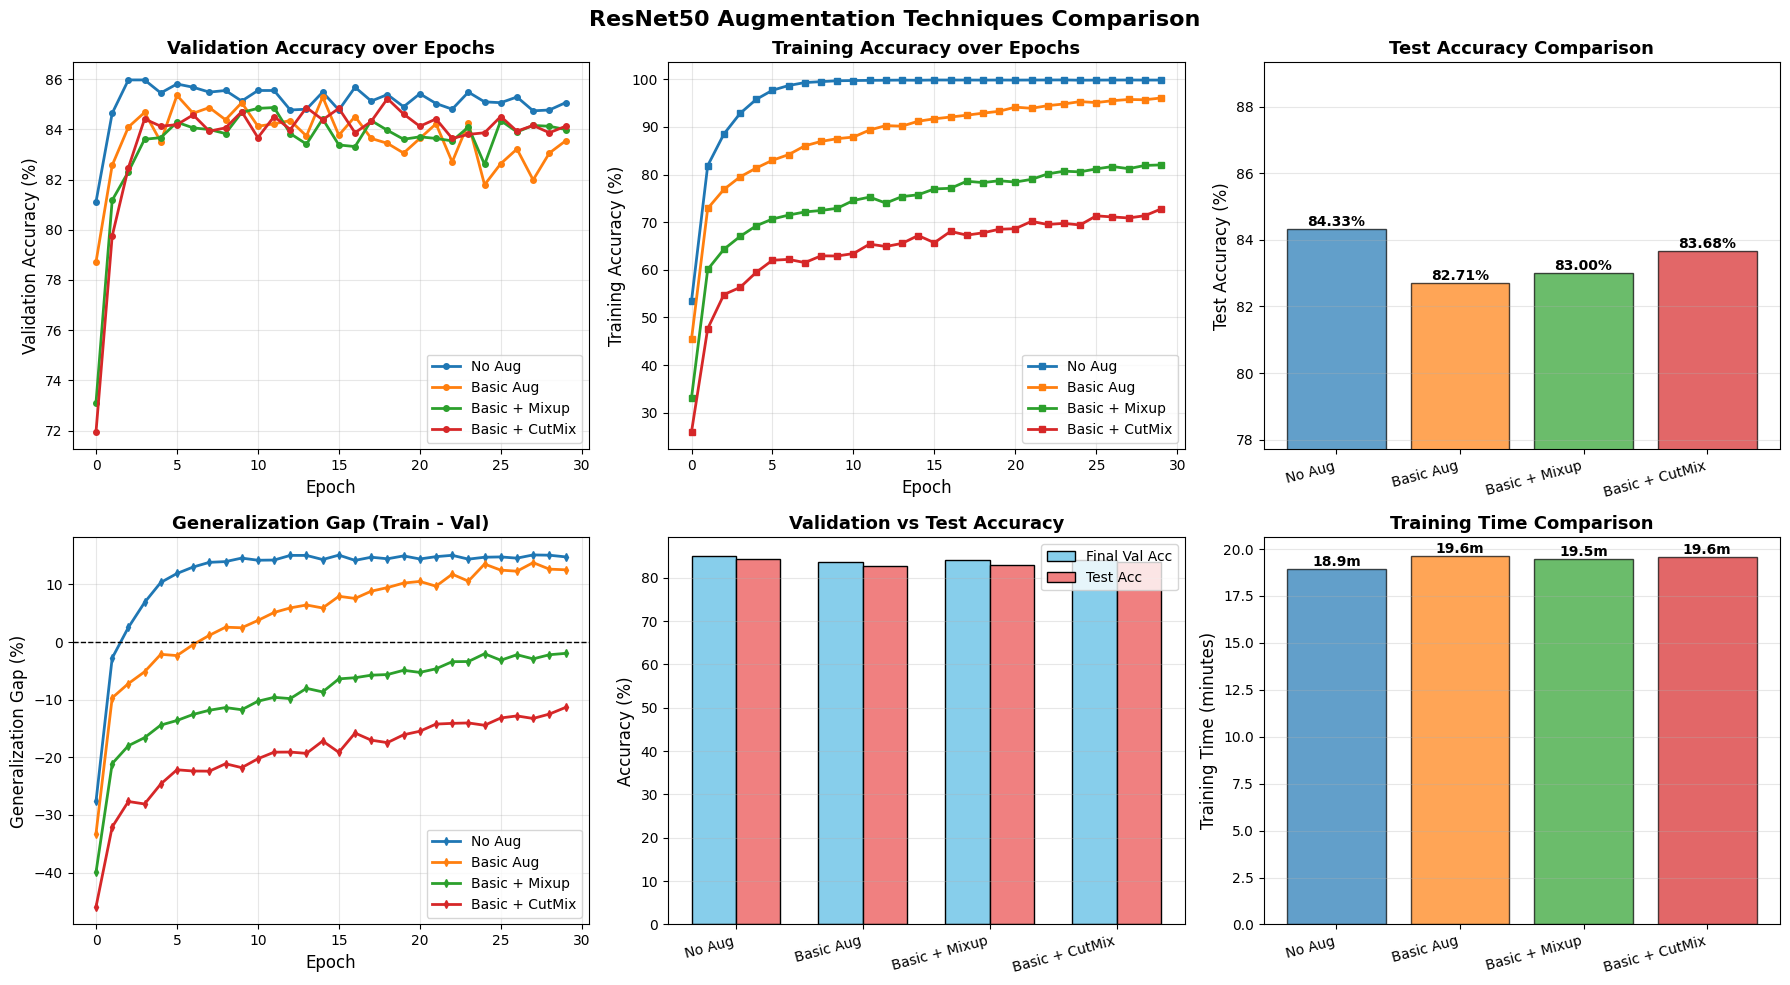


ANALYSIS & INTERPRETATION

1. 일반화 성능 (Generalization):
--------------------------------------------------------------------------------
No Aug                   : Train-Val Gap =  14.77%  (Train: 99.84%, Val: 85.07%)
Basic Aug                : Train-Val Gap =  12.53%  (Train: 96.08%, Val: 83.54%)
Basic + Mixup            : Train-Val Gap =  -1.97%  (Train: 82.03%, Val: 84.00%)
Basic + CutMix           : Train-Val Gap = -11.35%  (Train: 72.77%, Val: 84.13%)

2. 강건성 (Robustness):
--------------------------------------------------------------------------------
No Aug                   : Val-Test Diff =   0.74%  (Val: 85.07%, Test: 84.33%)
Basic Aug                : Val-Test Diff =   0.84%  (Val: 83.54%, Test: 82.71%)
Basic + Mixup            : Val-Test Diff =   1.00%  (Val: 84.00%, Test: 83.00%)
Basic + CutMix           : Val-Test Diff =   0.45%  (Val: 84.13%, Test: 83.68%)

3. 최종 성능 순위 (Test Accuracy):
--------------------------------------------------------------------------------
1. No

In [ ]:
print("\n" + "="*80)
print("COMPREHENSIVE RESULTS COMPARISON")
print("="*80)

print(f"\n{'Method':<25} {'Epochs':<10} {'Train Time':<12} {'Best Train':<12} "
      f"{'Best Val':<12} {'Final Train':<12} {'Final Val':<12} {'Test Acc':<10}")
print("-"*120)
methods = ['No Aug', 'Basic Aug', 'Basic + Mixup', 'Basic + CutMix']
for method in methods:
    r = results[method]
    print(f"{method:<25} {r['epochs_trained']:<10} {r['total_time']/60:<12.2f} {r['best_train_acc']:<12.2f} "
          f"{r['best_val_acc']:<12.2f} {r['final_train_acc']:<12.2f} "
          f"{r['final_val_acc']:<12.2f} {r['test_acc']:<10.2f}")

# 시각화
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('ResNet50 Augmentation Techniques Comparison', fontsize=16, fontweight='bold')

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

# 1. Validation Accuracy
ax = axes[0, 0]
for method, color in zip(methods, colors):
    ax.plot(histories[method]['val_accuracy'], label=method, linewidth=2, color=color, marker='o', markersize=4)
ax.set_xlabel('Epoch', fontsize=12)
ax.set_ylabel('Validation Accuracy (%)', fontsize=12)
ax.set_title('Validation Accuracy over Epochs', fontsize=13, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

# 2. Training Accuracy
ax = axes[0, 1]
for method, color in zip(methods, colors):
    ax.plot(histories[method]['train_accuracy'], label=method, linewidth=2, color=color, marker='s', markersize=4)
ax.set_xlabel('Epoch', fontsize=12)
ax.set_ylabel('Training Accuracy (%)', fontsize=12)
ax.set_title('Training Accuracy over Epochs', fontsize=13, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

# 3. Test Accuracy Comparison (Bar Chart)
ax = axes[0, 2]
test_accs = [results[m]['test_acc'] for m in methods]
bars = ax.bar(range(len(methods)), test_accs, color=colors, alpha=0.7, edgecolor='black')
ax.set_xticks(range(len(methods)))
ax.set_xticklabels(methods, rotation=15, ha='right')
ax.set_ylabel('Test Accuracy (%)', fontsize=12)
ax.set_title('Test Accuracy Comparison', fontsize=13, fontweight='bold')
ax.set_ylim([min(test_accs)-5, max(test_accs)+5])
for i, bar in enumerate(bars):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.2f}%', ha='center', va='bottom', fontsize=10, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')

# 4. Generalization Gap (Train - Val Accuracy)
ax = axes[1, 0]
for method, color in zip(methods, colors):
    gap = np.array(histories[method]['train_accuracy']) - np.array(histories[method]['val_accuracy'])
    ax.plot(gap, label=method, linewidth=2, color=color, marker='d', markersize=4)
ax.set_xlabel('Epoch', fontsize=12)
ax.set_ylabel('Generalization Gap (%)', fontsize=12)
ax.set_title('Generalization Gap (Train - Val)', fontsize=13, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)
ax.axhline(y=0, color='black', linestyle='--', linewidth=1)

# 5. Val vs Test Accuracy (Robustness)
ax = axes[1, 1]
final_val = [results[m]['final_val_acc'] for m in methods]
test_accs = [results[m]['test_acc'] for m in methods]
x = np.arange(len(methods))
width = 0.35
bars1 = ax.bar(x - width/2, final_val, width, label='Final Val Acc', color='skyblue', edgecolor='black')
bars2 = ax.bar(x + width/2, test_accs, width, label='Test Acc', color='lightcoral', edgecolor='black')
ax.set_xticks(x)
ax.set_xticklabels(methods, rotation=15, ha='right')
ax.set_ylabel('Accuracy (%)', fontsize=12)
ax.set_title('Validation vs Test Accuracy', fontsize=13, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3, axis='y')

# 6. Training Time Comparison
ax = axes[1, 2]
train_times = [results[m]['total_time']/60 for m in methods]
bars = ax.bar(range(len(methods)), train_times, color=colors, alpha=0.7, edgecolor='black')
ax.set_xticks(range(len(methods)))
ax.set_xticklabels(methods, rotation=15, ha='right')
ax.set_ylabel('Training Time (minutes)', fontsize=12)
ax.set_title('Training Time Comparison', fontsize=13, fontweight='bold')
for i, bar in enumerate(bars):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.1f}m', ha='center', va='bottom', fontsize=10, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('augmentation_comparison.png', dpi=300, bbox_inches='tight')
plt.show()


print("\n" + "="*80)
print("ANALYSIS & INTERPRETATION")
print("="*80)

print("\n1. 일반화 성능 (Generalization):")
print("-" * 80)
for method in methods:
    gap = results[method]['final_train_acc'] - results[method]['final_val_acc']
    print(f"{method:<25}: Train-Val Gap = {gap:>6.2f}%  "
          f"(Train: {results[method]['final_train_acc']:.2f}%, Val: {results[method]['final_val_acc']:.2f}%)")

print("\n2. 강건성 (Robustness):")
print("-" * 80)
for method in methods:
    val_test_diff = abs(results[method]['final_val_acc'] - results[method]['test_acc'])
    print(f"{method:<25}: Val-Test Diff = {val_test_diff:>6.2f}%  "
          f"(Val: {results[method]['final_val_acc']:.2f}%, Test: {results[method]['test_acc']:.2f}%)")

print("\n3. 최종 성능 순위 (Test Accuracy):")
print("-" * 80)
sorted_methods = sorted(methods, key=lambda x: results[x]['test_acc'], reverse=True)
for i, method in enumerate(sorted_methods, 1):
    print(f"{i}. {method:<25}: {results[method]['test_acc']:.2f}%")

print("\n4. 효율성 (Training Time):")
print("-" * 80)
for method in methods:
    print(f"{method:<25}: {results[method]['total_time']/60:>6.2f} minutes")

